In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import argparse
import pickle
from constants import *

# Set the font globally
# plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.family'] = 'Times New Roman'

parser = argparse.ArgumentParser()
parser.add_argument('--trial', type=str, help='trial name')
parser.add_argument('--log_dir', type=str, default='log', help='log file directory')
parser.add_argument('--pkl_path', type=str, default='')
parser.add_argument('--target', type=str, default='mrr', choices=['mrr', 'epoch'])
parser.add_argument('--num_scope', type=int, default=25, help='trial name')
parser.add_argument('--num_neighbor', type=int, default=10, help='trial name')
parser.add_argument('--runs', type=int, default=5, help='trial name')
parser.add_argument('--layers', type=int, default=1, help='layer number')
parser.add_argument('--fontsize', type=int, default=36, help='font size')
parser.add_argument('--no_title', action='store_true')
parser.add_argument('--save_legends', action='store_true')

args = parser.parse_args(['--layers', '12', '--pkl_path', '../all_mrrs_0318.pkl'])
log_dir = args.log_dir
config_dir = 'config' + '/{}'.format(args.trial)
# Optionally, you can set the font size as well
plt.rcParams['font.size'] = args.fontsize
if args.layers == 1:
    # scans = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '20', '50', '100']
    scans = ['5', '10', '20', '50', '100']
elif args.layers == 2:
    scans = ['5x5', '5x10', '10x5', '10x10']
else:
    scans = [['5', '10', '20', '50', '100'], 
             ['5x5', '5x10', '10x5', '10x10']]
# datasets = ['WIKI', 'REDDIT', 'Flights', 'LASTFM', 'mooc', 'uci', 'CollegeMsg']
datasets = ['WIKI', 'REDDIT']
memorys = ['gru', 'embed',]


In [2]:
all_data = {}

# load data
if os.path.exists(args.pkl_path):
    with open(args.pkl_path, 'rb') as f:
        all_data = pickle.load(f)
else:
    raise NotImplementedError


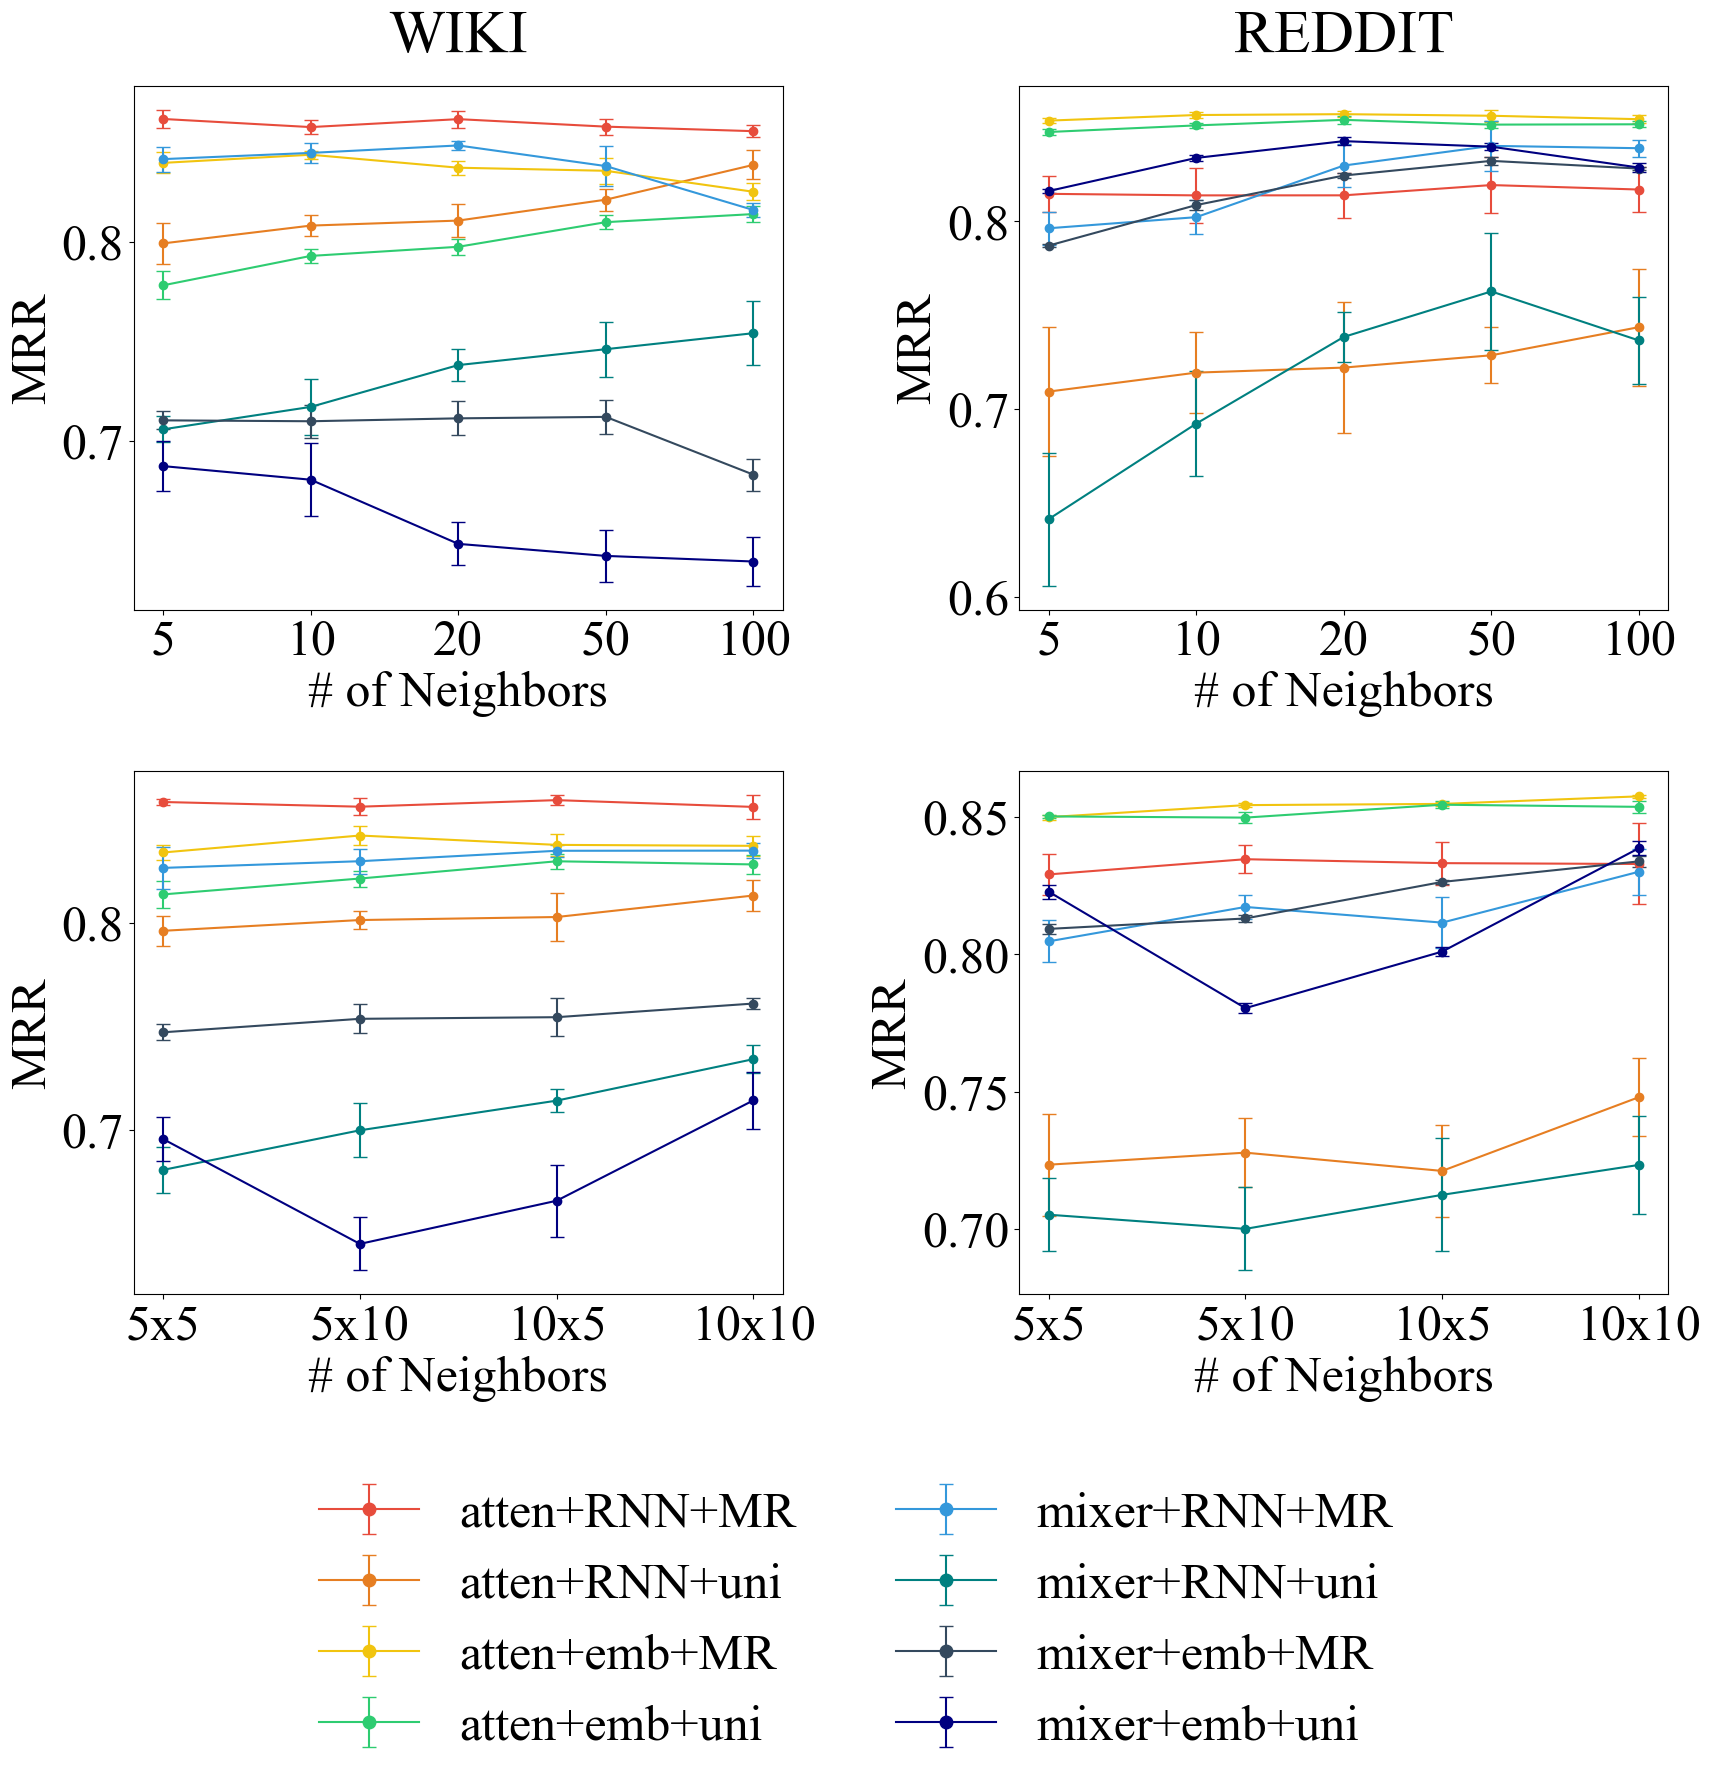

In [12]:
if args.layers != 12:
    fig, axes = plt.subplots(len(datasets)//2, 2, figsize=(18, 7.5*len(datasets)//2))
else:
    fig, axes = plt.subplots(len(datasets), 2, figsize=(18, 7.5*len(datasets)))
handles = []

for i, ax in enumerate(axes.flat):
    df_mean = pd.DataFrame()
    df_std = pd.DataFrame()
    df_all = pd.DataFrame()
    new_cols_mean = []
    new_cols_std = []
    dataset = datasets[i] if args.layers != 12 else datasets[i % 2]
    for aggr in aggrs:
        for memory in memorys:
            for spl in samplings:
                means = []
                stds = []
                this_scans = scans if args.layers != 12 else scans[i // 2]
                for scan in this_scans:
                    results = np.array(all_data[dataset][scan][aggr][spl][memory])
                    if len(results) == args.runs:
                        means.append(np.mean(results))
                        stds.append(np.std(results))
                    else:
                        print(dataset, scan, aggr, memory, len(results))
                if len(means) == len(this_scans):
                    df_mean[f"{show_aggrs[aggr]}+{show_memorys[memory]}+{show_samplings[spl]}"] = means
                    df_std[f"{show_aggrs[aggr]}+{show_memorys[memory]}+{show_samplings[spl]}"] = stds
                    # df_all[f"{show_aggrs[aggr]}+{show_memorys[memory]}+{show_samplings[spl]}"] = [(str(round(mean, 4)) + '+-' + str(round(std, 4))) for (mean, std) in zip(means, stds)]
                else:
                    print(len(means))
    if df_mean.empty:
        continue
    for ii, col in enumerate(df_mean.columns):
        ret = ax.errorbar(x=range(len(this_scans)), y=df_mean[col], yerr=df_std[col], fmt='-o', capsize=5, label=col, color=large_colors[ii])
        # ret = ax.bar(x=np.array(range(len(scans)))+0.12*i-0.18, height=df_mean[col], width=0.1, capsize=5, label=col, color=colors[i])
        if len(handles) < 8:
            handles.append(ret)
        new_cols_mean.append(col+f"_{dataset}_{i//2+1}l_mean")
        new_cols_std.append(col+f"_{dataset}_{i//2+1}l_std")
    
    df_mean.columns = new_cols_mean
    df_std.columns = new_cols_std
    df_all = pd.concat([df_mean, df_std], axis=1)
    df_all.to_csv(f'../tikz_data/all_comb_{dataset}_{i//2+1}l.csv', index=False)


    if dataset == 'mooc':
        title_str = f'{dataset.upper()}'
    else:
        title_str = f'{dataset}'
    
    if not args.no_title:
        if args.layers == 12 and this_scans == scans[1]:
            pass
        else:
            ax.set_title(title_str, x=0.5, y=1.05)
    x_labels = this_scans
    ax.set_xticks(ticks=np.arange(len(x_labels)), labels=x_labels)
    ax.set_xlabel(f'# of Neighbors')
    ax.set_ylabel(f'MRR')

plt.tight_layout()
fig.legend(handles=handles, frameon=False, bbox_to_anchor=(0.5, -0.11), loc='center', fontsize=36, borderaxespad=0, markerscale=1.5, ncol=2)
plt.savefig(f'../figures/all_datasets_mrr_spl_count_{args.layers}l.pdf', bbox_inches='tight')

In [ ]:
if args.save_legends:
    # Step 1: Create dummy figure and axes
    fig, ax = plt.subplots()

    # Step 2: Define your handles and labels
    # handles = []
    # for i,col in enumerate(df_mean.columns):
    #     handles.append(mpatches.Patch(color=colors[i], label=col))
        
    # Step 3: Create the legend
    legend = ax.legend(handles=handles, loc='center', ncol=len(handles)/3, frameon=False)

    # Step 4: Remove the axes
    ax.axis('off')

    # Step 5: Save the legend to a PDF file
    fig.canvas.draw()
    bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('figures/legend.pdf', bbox_inches=bbox)